#Learning covariance and correlation dictionaries on zebrafish development data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat, savemat
sns.set_context('notebook')

In [2]:
import covdict
import time
from numpy import any, arange, argmax, argsort, corrcoef, cov, isnan, triu_indices, vstack

##Load, color-code, and visualize data

#### Load data (thanks to Yinan Wan & Philipp Keller)

In [3]:
path = '/tier2/freeman/Clara/keller.lab/maturation/data/'
d = loadmat(path + 'dff_polyfit.mat')
dff = d['dff']
coords = d['tracks_smoothed']

# Remove cells with incomplete tracking
trash_idx = any(isnan(dff), axis=1)
dff = dff[~trash_idx, :]
coords = coords[~trash_idx, :, :]

#### Create bilateral colormap

In [4]:
# Number of tracked cells and samples
n, n_samp = dff.shape

# Line separating two sides of spinal cord
m = -100 / float(350)
b = 505
idx = coords[:, -1, 1] > m * coords[:, -1, 0] + b
hi_idx = np.where(idx)[0]
lo_idx = np.where(~idx)[0]

# Number of cells on each side
n_hi = hi_idx.shape[0]
n_lo = lo_idx.shape[0]

# Sort by z-coordinate (ventral-dorsal)
hz_idx = np.argsort(coords[hi_idx, -1, 2])
lz_idx = np.argsort(coords[lo_idx, -1, 2])
cell_idx = np.hstack((hi_idx[hz_idx], lo_idx[lz_idx])) 

dff = dff[cell_idx, :]
coords = coords[cell_idx, :, :]

# Two colormaps
n_col = 3
hi_cm = sns.cubehelix_palette(3, start=2, rot=-0.1, gamma=1, hue=1, dark=0.3, light=0.8, reverse=True)
lo_cm = sns.cubehelix_palette(3, start=0.8, rot=0, gamma=0.9, hue=1, dark=0.3, light=0.8, reverse=True)

colors = np.empty((n, 3))
colors[: n_hi, :] = np.tile(hi_cm, [1, np.ceil(n_hi / float(3)).astype(int)]).reshape(-1, 3)[: n_hi, :]
colors[n_hi :, :] = np.tile(lo_cm, [1, np.ceil(n_lo / float(3)).astype(int)]).reshape(-1, 3)[: n_lo, :]

#### Plot x-y (posterior-anterior, left-right) and y-z (left-right, ventral-dorsal) views of cells

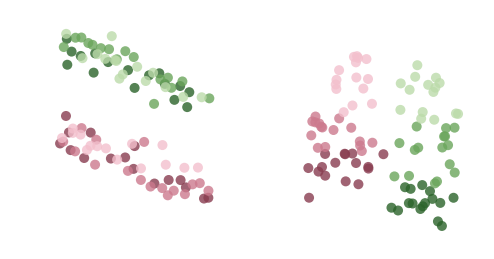

In [5]:
sns.set(rc={'axes.facecolor':'white', 'axes.grid':'off'})
plt.figure(figsize=(8, 4));

plt.subplot(121);
plt.scatter(coords[:, -1, 0], coords[:, -1, 1], s=100, linewidth=0, alpha=0.8, c=colors);
plt.axis('off');
plt.subplot(122);
plt.scatter(coords[:, -1, 1], coords[:, -1, 2], s=100, linewidth=0, alpha=0.8, c=colors);
plt.axis('off');

## Learning covariance dictionary using ALS vs. ADMM

#### Compute sample covariance matrices over time

In [6]:
# Window size = minutes x 60 seconds per minute x 4 Hz sampling
win = 5 * 60 * 4 
shift = 0.2
n_win = (n_samp - win) / int(shift * win) + 1

# Sample covariance per time window
X = vstack([cov(dff[:, i : i + win])[triu_indices(n)] for i in arange(0, n_samp, shift * win)]).T

#### Learn dictionary using ALS

Initial gradient norm: 148.237250.
Iter: 0. Projected gradient norm: 10.234412. Objective: 5.770889.
Iter: 1. Projected gradient norm: 0.002021. Objective: 0.563732.
Iter: 2. Projected gradient norm: 0.001498. Objective: 0.523588.
Iter: 3. Projected gradient norm: 0.001584. Objective: 0.520896.
Iter: 4. Projected gradient norm: 0.001577. Objective: 0.520509.
Iter: 5. Projected gradient norm: 0.001591. Objective: 0.520466.
Iter: 6. Projected gradient norm: 0.001591. Objective: 0.520466.
Iter: 7. Final projected gradient norm 0.001369. Final objective 0.520466.
12.4243531227 seconds


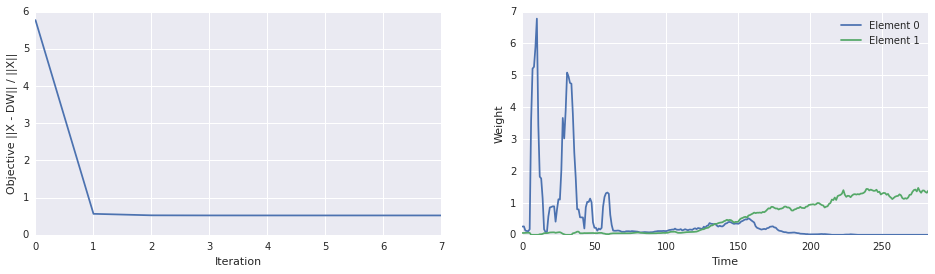

In [9]:
k = 2 # number of dictionary elements
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, 
                                   nls_beta=0.9, psdls_beta=0.9)
t = time.time()
Wals = als.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_win);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

#### Visualize ALS dictionary elements

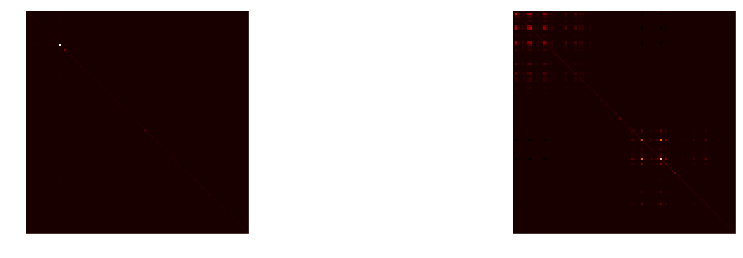

In [10]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(als.dictionary)
vmax = np.max(als.dictionary)

# Bilateral covariance matrix is clearly pulled out
for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(als.dictionary[:, i], n)
    plt.imshow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.axis('off');

#### Learn dictionary using ADMM

Iter: 0. Objective: 5.770889.
Iter: 100. Objective: 0.613706.
Iter: 200. Objective: 0.522733.
Iter: 248. Objective: 0.520586.
9.26213788986 seconds


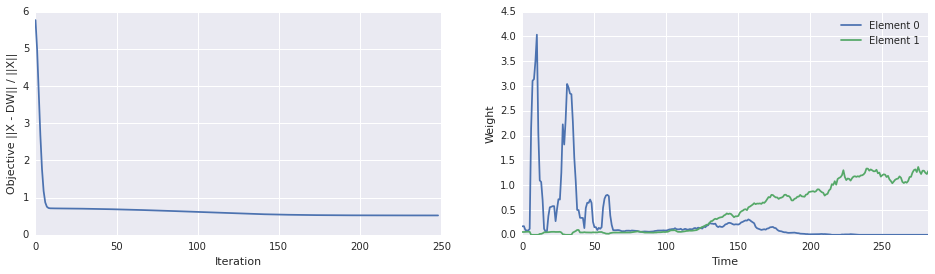

In [11]:
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, 
                                   admm_alpha=0.1, admm_gamma=1)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

# Can see stereotypic linear convergence of ADMM
plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_win);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

#### Visualize ADMM dictionary elements

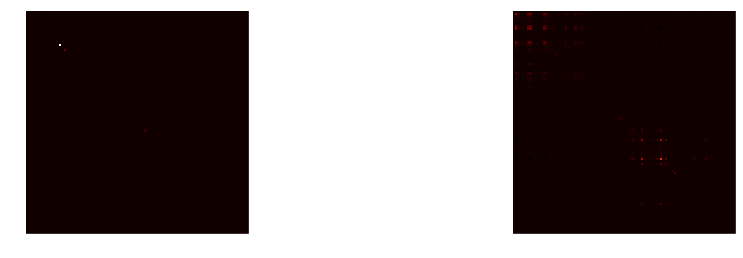

In [12]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admm.dictionary)
vmax = np.max(admm.dictionary)

# Bilateral covariance is clearly pulled out
for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(admm.dictionary[:, i], n)
    plt.imsh ow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.axis('off');

#### Plot objective over time for ALS vs. ADMMX

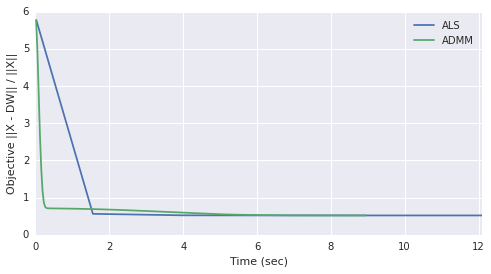

In [27]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max([als.times[-1], admm.times[-1]]));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);

#### Compare dictionary elements learned using ALS vs. ADMM

In [15]:
als_idx = argsort(argmax(Wals, axis=1))
admm_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to compare corresponding dictionary elements
# to account for scale factor
print "Correlations between corresponding dictionary elements learned by ALS and ADMM:"
for a, b in zip(als.dictionary[:, als_idx].T, admm.dictionary[:, admm_idx].T):
    print corrcoef(a, b)[0, 1]

Correlations between corresponding dictionary elements learned by ALS and ADMM:
0.999951015331
0.999996157017


## Learn dictionary of correlation matrices using ADMM

Iter: 0. Objective: 0.527040.
Iter: 100. Objective: 0.376578.
Iter: 132. Objective: 0.375787.
5.43405604362 seconds


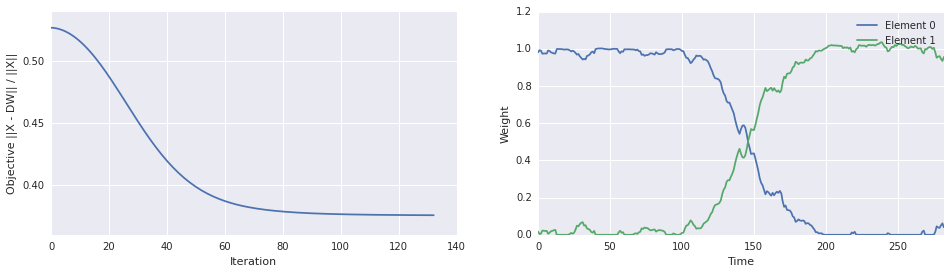

In [26]:
# Compute sample correlation matrices per time window
X = vstack([corrcoef(dff[:, i : i + win])[triu_indices(n)] 
            for i in arange(0, n_samp, shift * win)]).T

# Run ADMM
admmc = covdict.CovarianceDictionary(k=k, method='admm', correlation=True,
                                         verbose=True, time=True, admm_alpha=0.2, admm_gamma=1)
t = time.time()
Wadmmc = admmc.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admmc.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmmc.T);
plt.xlim(0, n_win);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

#### Visualize ADMM correlation dictionary elements

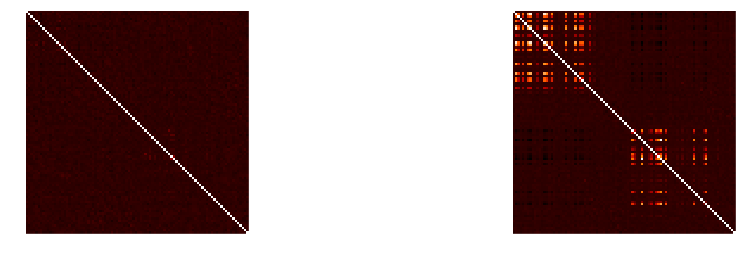

In [28]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admmc.dictionary)
vmax = np.max(admmc.dictionary)

# Bilateral correlation matrix is clearly pulled out
for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(admmc.dictionary[:, i], n)
    plt.imshow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.axis('off');

#### More dictionary elements!

Iter: 0. Objective: 0.524942.
Iter: 100. Objective: 0.367712.
Iter: 200. Objective: 0.359643.
Iter: 292. Objective: 0.357855.
29.0332410336 seconds


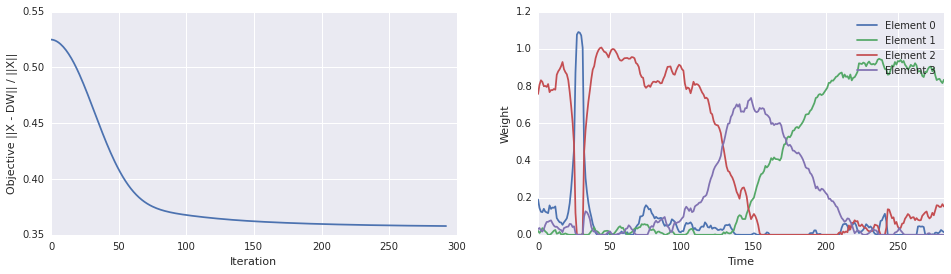

In [33]:
k = 4
admmc2 = covdict.CovarianceDictionary(k=k, method='admm', correlation=True,
                                         verbose=True, time=True, admm_alpha=0.2, admm_gamma=1)
t = time.time()
Wadmmc2 = admmc2.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admmc2.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmmc2.T);
plt.xlim(0, n_win);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

#### Visualize ADMM correlation dictionary elements

In [ ]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admmc2.dictionary)
vmax = np.max(admmc2.dictionary)

# Bilateral correlation matrix is clearly pulled out
for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(admmc2.dictionary[:, i], n)
    plt.imshow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.axis('off');